# Synthetic dataset generation

This notebook lets you generate a set of readings from random walks, used to define features and labels for the classification task. The pair of coordinates `(x,y)` is treated as set of features, the combination of the rounded first digit of both coordinates is used as class label. E.g., `(1.12,3.22)` is associated to class label `"1:3"`. Class labels identify a cell in the unit grid. Gaussian noise is added to model errors and uncertainty in the position readings. The set of possible states is bounded to the range of ammissible values for `x` and `y`, within the range `[0,world_limit]` values.

The random walk advances by changes in `x` and `y` bounded within the range `[0,step]` at each step. The initial position is the center of the admissible positions, `[world_limit/2,world_limit/2]`. Each sample is associated to a timestamp, that is incremented at each step. Each trajectory is identified by a distinct session ID. In the default configuration, we consider only one session by setting `n_sessions` to `1`.

The generated dataset is represented by three output datasets:

* `data/train.csv`: labeled dataset of `20000` samples, to be used for training
* `data/test.csv`: labeled dataset of `20000` samples, to be used for testing
* `data/unlabeled.csv`: unlabeled dataset of `1000000` samples, to be used for learning the HMM transition matrix


In [1]:
# Imports

import numpy as np
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [2]:
# Configuration

# Parameters
world_limit = 4
step = .1
noise_std = .1
initial_position = [world_limit/2,world_limit/2]
n_sessions = 1
n_samples_train = 20000
n_samples_test = 20000
n_samples_unlabeled = 1000000
n_timestamps = n_samples_train + n_samples_test + n_samples_unlabeled


# Make results reproducible
np.random.seed(123)


In [3]:
# Generate ground truth and samples for measurements

measurements = []

for session_id in range(n_sessions):
    
    # all sessions start at same position
    prev_pos = initial_position
    
    for timestamp_id in range(n_timestamps):
        while True:
            pos = [prev_pos[0] + np.random.uniform(-step, step), prev_pos[1] + np.random.uniform(-step, step)]
            if pos[0] >= 0 and pos[0] <= world_limit and pos[1] >= 0 and pos[1] <= world_limit:
                break
    
        pos_sample = [pos[0] + np.random.normal(0, noise_std), pos[1] + np.random.normal(0, noise_std)]

        # taking absolute values so that all values are within 0 and world_limit.
        measurements.append([session_id,
                             timestamp_id,
                             pos[0],
                             pos[1],
                             pos_sample[0],
                             pos_sample[1]])
    
        prev_pos = pos


measurements = pd.DataFrame(measurements, columns=["session_id", "timestamp", "x_true", "y_true", "x_sample", "y_sample"])

# Meaning of columns:
# "session_id": Session ID of reading
# "timestamp": Timestamp of reading
# "x_true": x ground truth position of reading
# "y_true": y ground truth position of reading
# "x_sample": sampled noisy x value
# "y_sample": sampled noisy y value

# class label is equal to the combination of the first digit of the position on both axes
measurements["true_class"] = measurements.apply(lambda row: "{:.0f}:{:.0f}".format(row["x_true"], row["y_true"]), axis=1)

# basic classifier, extracts class label from noisy sample
measurements["predicted_class"] = measurements.apply(lambda row: "{:.0f}:{:.0f}".format(row["x_sample"], row["y_sample"]), axis=1)


In [4]:
measurements.head()

,session_id,timestamp,x_true,y_true,x_sample,y_sample,true_class,predicted_class
0,0,0,2.039294,1.957228,2.067592,1.806598,2:2,2:2
1,0,1,2.083188,1.941849,1.840520,1.898958,2:2,2:2
2,0,2,2.051823,1.987659,1.983935,1.978188,2:2,2:2
3,0,3,2.031432,2.035258,1.987034,1.991823,2:2,2:2
4,0,4,2.037742,2.041624,2.138148,2.080242,2:2,2:2


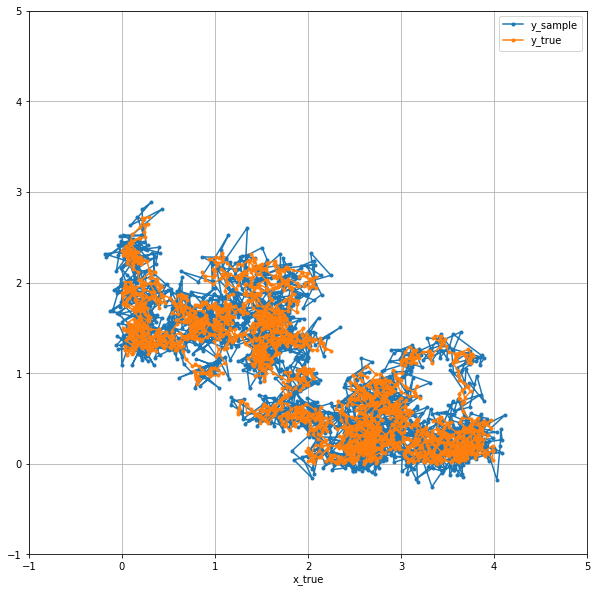

,session_id,timestamp,x_true,y_true,x_sample,y_sample,true_class,predicted_class
0,0,0,2.039294,1.957228,2.067592,1.806598,2:2,2:2
1,0,1,2.083188,1.941849,1.840520,1.898958,2:2,2:2
2,0,2,2.051823,1.987659,1.983935,1.978188,2:2,2:2
3,0,3,2.031432,2.035258,1.987034,1.991823,2:2,2:2
4,0,4,2.037742,2.041624,2.138148,2.080242,2:2,2:2


In [5]:
# Plot of the first 2000 steps in the random walk

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

measurements[:2000].set_index("x_sample")["y_sample"].plot(style=".-", ax=ax1)
measurements[:2000].set_index("x_true")["y_true"].plot(style=".-", ax=ax1)

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)
ax1.yaxis.set_major_locator(loc)

# extending the included area by one in all directions to accomodate the Gaussian noise,
# that might overflow the [0,world_limit] region.
ax1.set_xlim([-1,world_limit+1])
ax1.set_ylim([-1,world_limit+1])

# display legend and grid
ax1.legend()
ax1.grid()

plt.show()

measurements.head()

In [6]:
accuracy = len(measurements[measurements.true_class == measurements.predicted_class]) / len(measurements)
accuracy

0.8294336538461539

In [7]:
measurements.head()

,session_id,timestamp,x_true,y_true,x_sample,y_sample,true_class,predicted_class
0,0,0,2.039294,1.957228,2.067592,1.806598,2:2,2:2
1,0,1,2.083188,1.941849,1.840520,1.898958,2:2,2:2
2,0,2,2.051823,1.987659,1.983935,1.978188,2:2,2:2
3,0,3,2.031432,2.035258,1.987034,1.991823,2:2,2:2
4,0,4,2.037742,2.041624,2.138148,2.080242,2:2,2:2


In [8]:
measurements.true_class.nunique()

25

In [9]:
measurements.true_class.unique()

array(['2:2', '1:2', '2:1', '1:1', '0:1', '0:2', '0:3', '2:0', '1:0',
       '3:0', '3:1', '4:1', '4:0', '0:0', '3:2', '4:2', '4:3', '3:3',
       '4:4', '3:4', '2:3', '2:4', '1:3', '1:4', '0:4'], dtype=object)

The possible class labels reflect all combinations of first digits in a grid bounded within [0,4]. In other words, they identify a cell in the unit grid.

In [10]:
# split dataset in trian,test,unlabeled subsets
train_dataset = measurements[:n_samples_train]
test_dataset = measurements[n_samples_train:n_samples_train + n_samples_test]
unlabeled_dataset = measurements[n_samples_train + n_samples_test:]

len(measurements), len(train_dataset), len(test_dataset), len(unlabeled_dataset)

(1040000, 20000, 20000, 1000000)

In [11]:
# persist datasets. Please not that the unlabeled dataset has no "true_class" column, in contrast to the train and test datasets.
unlabeled_dataset[["session_id", "timestamp", "x_sample", "y_sample"]].to_csv("data/unlabeled.csv", index=False, float_format='%.2f')
train_dataset[["session_id", "timestamp", "x_sample", "y_sample", "true_class"]].to_csv("data/train.csv", index=False, float_format='%.2f')
test_dataset[["session_id", "timestamp", "x_sample", "y_sample", "true_class"]].to_csv("data/test.csv", index=False, float_format='%.2f')


In [12]:
!du -h data/*.csv

432.0K	data/test.csv
420.0K	data/train.csv
18.1M	data/unlabeled.csv


## Conclusions

We generated three datasets: train, test, and unlabeled. The unlabeled dataset is much bigger than the train and test datasets, to stress that in many applications there is scarcity of labeled data, and aboundance of unlabeled data.